In [16]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import seaborn as sns


In [17]:
def generate_dataset(n):
    np.random.seed(23)
    sigma = 1
    x = np.random.uniform (0, 1, n)
    err = np.random.normal(0, sigma, n) 
    f = 4*np.sin(np.pi*x)*np.cos(6*np.pi*x**2)
    y = 4*np.sin(np.pi*x)*np.cos(6*np.pi*x**2) + err
    x_order = x.argsort()
    x = x[x_order[::1]]
    x = x.reshape(x.shape[0],1)
    f = f[x_order[::1]]
    f = f.reshape(f.shape[0],1)
    y = y[x_order[::1]]
    y = y.reshape(y.shape[0],1)
    return x,f,y

In [18]:
def train(K,y,L):
    # a = argmin(Ka-y)^2+La^TKa
    # using closed-form solution:
    # a = (K+LI)^(-1)y
    m = (K + L*np.identity(K.shape[0]))
    a = scipy.linalg.solve(m,y)
    return a

In [19]:
def poly(x,z,d):
    k = (1+x.T.dot(z))**d
    return k

In [20]:
def rbf(x,z,r):
    k = np.exp(-r*(x-z)**2)
    return k

In [21]:
def form_kernel(x,kernel,param,x2=None):
    if x2 is None:
        x2 = x
    n = x.shape[0]
    m = x2.shape[0]
    K = np.zeros((n,m))
    for i in range(0,n):
        for j in range(0,m):
            K[i,j] = kernel(x[i],x2[j],param)
    return K

In [22]:
def pred(K,a):
    y = K.dot(a)
    return y
    

In [23]:
def kfold(K,y,k=5):
    K_trains = []
    K_vals = []
    y_trains = []
    y_vals = []
    #idx = np.random.permutation(K.shape[0])
    idx = np.random.RandomState(seed=23).permutation(K.shape[0])
    part_size = int(K.shape[0]/k)
    for i in range(0,k):
        start = i * part_size
        end = (i + 1) * part_size
        val_idx = idx[start:end]
        train_idx = np.concatenate((idx[0:start],idx[end:]))
        K_trains.append(  K[train_idx, :][:,train_idx]  ) 
        K_vals.append(K[val_idx, :][:, train_idx])
        y_trains.append(y[train_idx, :])
        y_vals.append(y[val_idx, :])
    return K_trains, K_vals, y_trains, y_vals

In [24]:
def MSE(y,y_pred):
    mse = ((y_pred-y)**2).mean()
    return mse

In [25]:
def loo(x,y,param_list, L_list,kernel):
    results = []
    for L in L_list:
        for param in param_list:
            mse_list = []
            for i in range(x.shape[0]):
                #print(i)
                cx = np.concatenate((x[:i],x[(i+1):]))
                cy = np.concatenate((y[:i],y[(i+1):]))
                x_i = x[i]
                x_i = x_i.reshape(x_i.shape[0],1)
                y_i = y[i]
                y_i = y_i.reshape(y_i.shape[0],1)
                K = form_kernel(cx,kernel,param,x2=None)
                #print(L)
                a = train(K,cy,L)
                Kc = form_kernel(x_i,kernel,param,x2=cx)
                y_pred = pred(Kc,a)
                mse = MSE(y_i,y_pred)
                #print(y_i,y_pred)
                mse_list.append(mse)
            results.append( ( np.mean(mse_list), param, L ) )
    min_mse = 1000
    best_param = 0
    best_L = 0
    for i in results: 
        mse_avg,param,L = i
        if mse_avg < min_mse:
            best_param = param
            best_L = L
            min_mse = mse_avg 
    return best_param,best_L, min_mse 

In [26]:
def cv(x,y,param_list, L_list,kernel,k):
    results = []
    for param in param_list:
        K = form_kernel(x,kernel,param,x2=None)
        K_trains, K_vals, y_trains, y_vals = kfold(K,y,k=k)
        for L in L_list:
            mse_list = []
            for i in range(k):
                a = train(K_trains[i],y_trains[i],L)
                y_pred = pred(K_vals[i],a)
                
                mse = MSE(y_vals[i],y_pred)
                mse_list.append(mse)
                #print("****np.mean(mse_list){}".format(mse))
            results.append( ( np.mean(mse_list), param, L ) )
            #print("mse{}".format(np.mean(mse_list)))
    min_mse = 10000
    best_param = 0
    best_L = 0
    #print (results)
    for i in results: 
        mse_avg,param,L = i
        if mse_avg < min_mse:
            best_param = param
            best_L = L
            min_mse = mse_avg 
    return best_param,best_L, min_mse       

In [27]:
'''Q1 hyperparameter tuning'''
x,f,y = generate_dataset(30)
param_list_poly= np.arange(1,100,5)
param_list_rbf= np.arange(8, 11,0.5)
L_list = np.float_power( 10, np.arange(-8, 0) )
best_param_poly_loo,best_L_poly_loo, min_mse_poly_loo  = loo(x,y,param_list_poly,L_list,poly)
best_param_rbf_loo,best_L_rbf_loo, min_mse_rbf_loo = loo(x,y,param_list_rbf,L_list,rbf)
x,f,y = generate_dataset(300)
best_param_poly_cv,best_L_poly_cv, min_mse_poly_cv  = cv(x,y,param_list_poly,L_list,poly,10)
best_param_rbf_cv,best_L_rbf_cv, min_mse_rbf_cv  = cv(x,y,param_list_rbf,L_list,rbf,10)

print('best_L_poly_cv:{}, best_param_poly_cv:{}, min_mse_poly_cv:{}'.format(best_L_poly_cv, best_param_poly_cv,min_mse_poly_cv))
print('best_L_poly_loo:{}, best_param_poly_loo:{}, min_mse_poly_loo:{}'.format(best_L_poly_loo, best_param_poly_loo,min_mse_poly_loo))
print('best_L_rbf_cv:{}, best_param_rbf_cv:{}, min_mse_rbf_cv:{}'.format(best_L_rbf_cv, best_param_rbf_cv,min_mse_rbf_cv))
print('best_L_rbf_loo:{}, best_param_rbf_loo:{}, min_mse_rbf_loo:{}'.format(best_L_rbf_loo, best_param_rbf_loo,min_mse_rbf_loo))




/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.01116e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.86869e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.06901e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.27633e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.15739e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.87474e-17): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.86345e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.20297e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.21889e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.04213e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.20564e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.72518e-21): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.11095e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.98113e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.37964e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.68163e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.59773e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.94653e-25): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.34048e-27): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.91761e-28): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.11848e-27): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.17298e-27): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.71015e-28): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.1417e-28): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.65333e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.98372e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.67399e-31): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.02682e-31): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.00725e-31): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.33698e-31): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.28348e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.19969e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.10417e-35): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.01313e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.29102e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.27692e-34): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.40856e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.55932e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.46766e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.54398e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.40152e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.51801e-17): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.8455e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.94495e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.2407e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.06158e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.06438e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.00942e-20): result may not be a

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.33898e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.49128e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.51431e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.41683e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.76209e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.9524e-25): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.15393e-28): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.65239e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.97521e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.58306e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.46283e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.99257e-28): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.07668e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.90209e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.29693e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.74757e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.98742e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.4515e-32): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.35195e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.71677e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.49892e-35): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.80597e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.22753e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.18988e-34): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.43603e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.56496e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.52161e-22): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.3135e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.88291e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.56455e-22): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.59632e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.42468e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.46401e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.23876e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.10099e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.27974e-26): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.28692e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.14476e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.06745e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.71131e-28): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.54398e-28): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.14757e-27): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.95281e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.63419e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.49121e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.09938e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.55251e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.14592e-32): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.80559e-35): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.59732e-36): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.78631e-35): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.53258e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.10018e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.88259e-17): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.76804e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.32165e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.76333e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.74172e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.20361e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.15858e-20): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.77976e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.69653e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.78747e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.97628e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.02169e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.03328e-25): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.04225e-27): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.77333e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.13527e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.13631e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.33779e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.20171e-29): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.78107e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.85021e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.70767e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.67597e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.47258e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.65082e-32): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.95952e-18): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.61692e-18): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.31857e-18): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.05396e-18): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.15571e-18): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.72789e-18): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.98946e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.25745e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.01495e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.19939e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.80064e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.00609e-21): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.88719e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.74789e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.46281e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.0378e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.62744e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.11548e-25): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.93783e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.07012e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.70033e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.34216e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.06897e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.2867e-30): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.37763e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.70198e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.96575e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.7211e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.2534e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.00612e-33): result may not be a

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.55436e-22): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.56909e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.58779e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.8302e-23): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.83263e-22): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.02713e-23): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.13983e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.13015e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.87364e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.93684e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.86189e-27): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.58937e-26): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.49049e-31): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.70745e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.40255e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.85261e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.94681e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.29192e-30): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.08034e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.6203e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.36477e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.29658e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.9092e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.5892e-32): result may not be ac

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.32624e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.68582e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.36592e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.86098e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.55606e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.26647e-19): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.70122e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.23174e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.27777e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.09362e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.09846e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.18807e-24): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.91341e-27): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.17547e-27): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.29779e-27): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.83847e-28): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.22974e-28): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.05237e-28): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.6631e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.00631e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.21731e-31): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.94907e-31): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.02096e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.03926e-32): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.47513e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.37603e-20): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.81725e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.2645e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.35274e-21): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.81515e-21): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.92489e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.80243e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.35265e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.70866e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.66275e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.52519e-25): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.215e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.29757e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.61091e-31): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.60614e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.4757e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.56514e-30): result may not be ac

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.83646e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.48239e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.58347e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.20011e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.01845e-17): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.68478e-17): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.9028e-22): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.31879e-23): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.38187e-22): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.86865e-22): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.44346e-22): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.86363e-23): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.13159e-24): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.74717e-24): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.56792e-24): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.04277e-23): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.49656e-24): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.75226e-25): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.17839e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.21188e-24): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.94877e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.7562e-25): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.54396e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.61531e-25): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.98243e-27): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.24808e-28): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.24741e-27): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.34293e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.77381e-26): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.40834e-27): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.1406e-28): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.23106e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.35873e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.69746e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.27009e-28): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.36605e-28): result may not be 

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.02776e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.57055e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.09244e-29): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.69754e-31): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.62518e-30): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.45449e-30): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.96242e-31): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.66016e-31): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.62948e-31): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.54278e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.05036e-32): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.13178e-31): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.75681e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.08805e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.45649e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.17231e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.38689e-33): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.25488e-32): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.24279e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.25438e-35): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.27323e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.38002e-34): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.43849e-35): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.05185e-35): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.07102e-35): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=4.36802e-35): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.11659e-35): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.42192e-35): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=7.84483e-36): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.47839e-36): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.14422e-37): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.58852e-37): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.98772e-37): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.30575e-38): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.58395e-38): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.49928e-38): result may not be

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=3.3252e-38): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.41726e-38): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=6.2997e-39): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.01813e-39): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.66386e-39): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.3826e-39): result may not be ac

/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.73487e-40): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.38834e-39): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=2.32351e-40): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=9.80074e-40): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.35598e-40): result may not be accurate.
  
/Users/yyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=8.07602e-41): result may not be

best_L_poly_cv:0.001, best_param_poly_cv:36, min_mse_poly_cv:0.9808363297876218
best_L_poly_loo:0.0001, best_param_poly_loo:36, min_mse_poly_loo:1.2602873644640467
best_L_rbf_cv:1e-08, best_param_rbf_cv:10.5, min_mse_rbf_cv:0.9945152221742573
best_L_rbf_loo:0.0001, best_param_rbf_loo:10.5, min_mse_rbf_loo:1.7351916230348539


In [28]:
print('best_L_poly_cv:{}, best_param_poly_cv:{}, min_mse_poly_cv:{}'.format(best_L_poly_cv, best_param_poly_cv,min_mse_poly_cv))
print('best_L_poly_loo:{}, best_param_poly_loo:{}, min_mse_poly_loo:{}'.format(best_L_poly_loo, best_param_poly_loo,min_mse_poly_loo))
print('best_L_rbf_cv:{}, best_param_rbf_cv:{}, min_mse_rbf_cv:{}'.format(best_L_rbf_cv, best_param_rbf_cv,min_mse_rbf_cv))
print('best_L_rbf_loo:{}, best_param_rbf_loo:{}, min_mse_rbf_loo:{}'.format(best_L_rbf_loo, best_param_rbf_loo,min_mse_rbf_loo))

best_L_poly_cv:0.001, best_param_poly_cv:36, min_mse_poly_cv:0.9808363297876218
best_L_poly_loo:0.0001, best_param_poly_loo:36, min_mse_poly_loo:1.2602873644640467
best_L_rbf_cv:1e-08, best_param_rbf_cv:10.5, min_mse_rbf_cv:0.9945152221742573
best_L_rbf_loo:0.0001, best_param_rbf_loo:10.5, min_mse_rbf_loo:1.7351916230348539


In [29]:
print('best_L_poly_cv:{}, best_param_poly_cv:{}, min_mse_poly_cv:{}'.format(best_L_poly_cv, best_param_poly_cv,min_mse_poly_cv))
print('best_L_poly_loo:{}, best_param_poly_loo:{}, min_mse_poly_loo:{}'.format(best_L_poly_loo, best_param_poly_loo,min_mse_poly_loo))
print('best_L_rbf_cv:{}, best_param_rbf_cv:{}, min_mse_rbf_cv:{}'.format(best_L_rbf_cv, best_param_rbf_cv,min_mse_rbf_cv))
print('best_L_rbf_loo:{}, best_param_rbf_loo:{}, min_mse_rbf_loo:{}'.format(best_L_rbf_loo, best_param_rbf_loo,min_mse_rbf_loo))

best_L_poly_cv:0.001, best_param_poly_cv:36, min_mse_poly_cv:0.9808363297876218
best_L_poly_loo:0.0001, best_param_poly_loo:36, min_mse_poly_loo:1.2602873644640467
best_L_rbf_cv:1e-08, best_param_rbf_cv:10.5, min_mse_rbf_cv:0.9945152221742573
best_L_rbf_loo:0.0001, best_param_rbf_loo:10.5, min_mse_rbf_loo:1.7351916230348539


In [30]:
'''Q3 bootstrapping '''
def bootstrap(x, y, kernel, param, L, B=300):
    x_plot = np.arange(0,1,0.001)
    x_plot = x_plot.reshape(x_plot.shape[0], 1)
    n = x.shape[0]
    f_array = np.zeros((B, x_plot.shape[0]))
    for i in range(B):
        idxs = np.random.choice(n, n)
        x_sub = x[idxs,:]
        y_sub = y[idxs,:]
        K = form_kernel(x_sub,kernel,param,x2=None)
        a = train(K, y_sub, L=L)
        kx = form_kernel(x_plot,kernel,param,x2= x_sub)
        f = pred(kx, a)
        f_array[i] = f[:,0]
        #print(f_array[i,:])
    #f_array[np.isnan(f_array)] = 0
    p5 = np.percentile(f_array, 5, axis=0)
    p95 = np.percentile(f_array, 95, axis=0)
    return(x, p5, p95)


In [31]:
def plotb( x,f,y,kernel,best_param,best_L,fig_name):
    plt.clf()
    K_poly = form_kernel(x,kernel,best_param,x2=None)
    a = train(K_poly,y,best_L)
    x_plot = np.arange(0,1,0.001)
    x_plot =  x_plot.reshape(x_plot.shape[0],1)
    K_plot = form_kernel(x_plot,kernel,best_param,x2=x)
    y_pred = pred(K_plot,a)
    f_plot = 4*np.sin(np.pi*x_plot)*np.cos(6*np.pi*x_plot**2)
    #x, p5, p95 = bootstrap(x, y, kernel,best_param, best_L, B=300)
    sns.set()
    plt.plot(x,y,'.',label ='y')
    plt.plot(x_plot,f_plot,'-',label = 'f')
    plt.plot(x_plot,y_pred,label = 'f_{}'.format(str(kernel)))
    #plt.plot(x_plot,y_pred_rbf_best,label = 'frbf')
    #plt.plot(x_plot,p5,'-',label = 'p5')
    #plt.plot(x_plot,p95,'-',label = 'p95')
    plt.title(fig_name+"_param_{}_lambda_{}".format(best_param,best_L))
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.ylim(-10, 10)
    plt.savefig(fig_name+'b.png')


In [32]:
def plot( x,f,y,kernel,best_param,best_L,fig_name):
    ker = str(kernel)
    plt.clf()
    K_poly = form_kernel(x,kernel,best_param,x2=None)
    a = train(K_poly,y,best_L)
    x_plot = np.arange(0,1,0.001)
    x_plot =  x_plot.reshape(x_plot.shape[0],1)
    K_plot = form_kernel(x_plot,kernel,best_param,x2=x)
    y_pred = pred(K_plot,a)
    f_plot = 4*np.sin(np.pi*x_plot)*np.cos(6*np.pi*x_plot**2)
    x, p5, p95 = bootstrap(x, y, kernel,best_param, best_L, B=300)
    sns.set()
    plt.plot(x,y,'.',label ='y')
    plt.plot(x_plot,f_plot,'-',label = 'f')
    plt.plot(x_plot,y_pred,label = 'f_{}'.format(ker))
    #plt.plot(x_plot,y_pred_rbf_best,label = 'frbf')
    plt.plot(x_plot,p5,'-.',label = 'p5')
    plt.plot(x_plot,p95,'-.',label = 'p95')
    plt.title(fig_name+"_param_{}_lambda_{}".format(best_param,best_L))
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.ylim(-10, 10)
    plt.savefig(fig_name+'.png')


In [51]:
x,f,y = generate_dataset(300)
plotb(x,f,y,rbf,best_param_rbf_cv,best_L_rbf_cv,'300_rbf')
plot(x,f,y,rbf,best_param_rbf_cv,best_L_rbf_cv,'300_rbf')

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [ ]:
x,f,y = generate_dataset(300)

plotb(x,f,y,poly,best_param_poly_cv,best_L_poly_cv,'300_poly')
plot(x,f,y,poly,best_param_poly_cv,best_L_poly_cv,'300_poly')

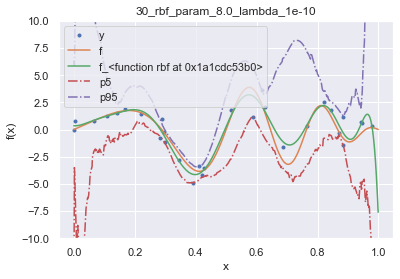

In [56]:
x,f,y = generate_dataset(30)
#plotb(x,f,y,rbf,best_param_rbf_loo,best_L_rbf_loo,'30_rbf')
plot(x,f,y,rbf,best_param_rbf_loo,best_L_rbf_loo,'30_rbf')

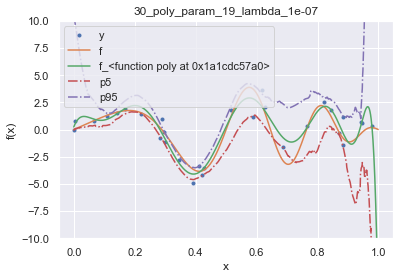

In [57]:
x,f,y = generate_dataset(30)
#plotb(x,f,y,poly,best_param_poly_loo,best_L_poly_loo,'30_poly')
plot(x,f,y,poly,best_param_poly_loo,best_L_poly_loo,'30_poly')

In [33]:
m = 1000
B = 300
x_train,f_train,y_train = generate_dataset(300)
x,f,y = generate_dataset(m)
K_poly = form_kernel(x_train,poly,best_param_poly_cv,x2=None)
a_poly = train(K_poly, y_train, L=best_L_poly_cv)
K_rbf = form_kernel(x_train,rbf,best_param_rbf_cv,x2=None)
a_rbf = train(K_rbf, y_train, L=best_L_rbf_cv)
f_array = np.zeros((1, B))
for i in range(B):
    print(i)
    idxs = np.random.choice(m, m)
    x_sub = x[idxs,:]
    y_sub = y[idxs,:]
    kx_poly = form_kernel(x_sub,poly,best_param_poly_cv,x2= x_train)
    f_poly = pred(kx_poly, a_poly)
    kx_rbf = form_kernel(x_sub,rbf,best_param_rbf_cv,x2= x_train)
    f_rbf = pred(kx_rbf, a_rbf)
    f = np.mean(np.power(y_sub-f_poly,2)-np.power(y_sub-f_rbf,2))
    #print(f)
    #print(len(set(idx)))
    f_array[0,i] = f
p5 = np.percentile(f_array, 5, axis = 1)
p95 = np.percentile(f_array, 95, axis = 1)

print("The confidence interval is ({},{})".format(p5,p95), flush = True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [172]:
p5 = np.percentile(f_array, 5, axis=1)
p95 = np.percentile(f_array, 95, axis=1)

In [173]:
p5

array([-0.03257349])

In [174]:
p95

array([0.01300723])

In [152]:
p5 = np.percentile(f_array, 5, axis=1)
p95 = np.percentile(f_array, 95, axis=1)

In [153]:
p5

array([-0.07354756])

In [154]:
p95

array([0.62931244])